# Forensic & Delta

## Beschreibung des Themas

# Code

### Download des Datensatzes

In [ ]:
!git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 579, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 579 (delta 150), reused 136 (delta 135), pack-reused 400 (from 2)
Receiving objects: 100% (579/579), 7.27 MiB | 13.39 MiB/s, done.
Resolving deltas: 100% (270/270), done.


### Installation von Delta Spark

In [ ]:
# https://docs.delta.io/latest/quick-start.html#create-a-table&language-python
!pip install delta-spark==4.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.1/434.1 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 kB 12.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-4.0.0-py2.py3-none-any.whl size=434741241 sha256=b63d47c99223c54a0a2a7e4a6ce2dde5620d9a11e10a33a7da4151476389b3e9
  Stored in directory: /root/.cache/pip/wheels/2d/77/9b/12660be70f7f447940a0caede37ae208b2e0d1c8487dce52a6
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-conn

In [ ]:
import pyspark
from delta import *
import matplotlib.pyplot as plt

# 1. Installiere OpenJDK 17
!sudo apt-get update
!apt-get install openjdk-17-jdk-headless -qq > /dev/null

# 2. Lade Spark 4.0.0 herunter und entpacke es
!wget -q https://dlcdn.apache.org/spark/spark-4.0.0/spark-4.0.0-bin-hadoop3.tgz
!tar -xf spark-4.0.0-bin-hadoop3.tgz

# 3. Installiere die Python-Bibliotheken
# Findspark fuer die Suche der Spark Biblitoheken da Pyspark nicht on sys.path standardmaessig ist
!pip install -q findspark
!pip install pyspark
# Ermoeglicht aus dem Python Interpreter Java Objekte in der java virtuellen Machine (JVM) zu erreichen
!pip install py4j

# 4. Setze die Umgebungsvariablen für Java 17 und Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-4.0.0-bin-hadoop3"

# 5. Initialisiere findspark und die SparkSession
import findspark
findspark.init()

from pyspark.sql import SparkSession

builder = pyspark.sql.SparkSession.builder.appName("MyApp") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,961 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,

In [ ]:
!mkdir tmp

### Konvertieren des Logs in DataFrame

In [ ]:
import re
import pandas as pd

with open("./loghub/Hadoop/Hadoop_2k.log") as f :
    log_lines = f.readlines()

# Der definierte reguläre Ausdruck
log_pattern = re.compile(
    r"^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3})\s+([A-Z]+)\s+\[([^\]]+)\]\s+([^:]+):\s*(.*)$"
)

def parse_log_line(line):
    """
    Parst eine einzelne Log-Zeile mit dem definierten Regex-Muster.
    Gibt ein Dictionary mit den extrahierten Feldern zurück oder None, wenn keine Übereinstimmung gefunden wird.
    """
    match = log_pattern.match(line)
    if match:
        return {
            "Timestamp": match.group(1),
            "LogLevel": match.group(2),
            "Thread": match.group(3),
            "Class": match.group(4),
            "Message": match.group(5).strip() # .strip() entfernt führende/nachfolgende Leerzeichen
        }
    return None

# Um dies für eine Datei zu tun, würden Sie alle Zeilen lesen und parsen:
# Angenommen, Sie haben eine Liste von Log-Zeilen


all_parsed_logs = [parse_log_line(line) for line in log_lines if parse_log_line(line) is not None]

# Erstellen des Pandas DataFrames
df_logs = pd.DataFrame(all_parsed_logs)
df_logs["Timestamp"] = pd.to_datetime(df_logs["Timestamp"], format="%Y-%m-%d %H:%M:%S,%f")
print("\nDataFrame mit konvertiertem Timestamp:")
df_logs


# Pandas to Spark
df_sp_lods = spark.createDataFrame(df_logs)



DataFrame mit konvertiertem Timestamp:


### DataFrame to Delta Table

In [ ]:

df_sp_lods.write.format("delta").save("/tmp/delta-table")

df = spark.read.format("delta").load("/tmp/delta-table")
df.show(n=5)

# Stoppen der SparkSession
#spark.stop()


+--------------------+--------+--------------------+--------------------+--------------------+
|           Timestamp|LogLevel|              Thread|               Class|             Message|
+--------------------+--------+--------------------+--------------------+--------------------+
|2015-10-18 18:06:...|    INFO|IPC Server handle...|org.apache.hadoop...|Progress of TaskA...|
|2015-10-18 18:06:...|    WARN|LeaseRenewer:msra...|org.apache.hadoop...|Address change de...|
|2015-10-18 18:06:...|    WARN|LeaseRenewer:msra...|org.apache.hadoop...|Failed to renew l...|
|2015-10-18 18:06:...|    INFO|IPC Server handle...|org.apache.hadoop...|Progress of TaskA...|
|2015-10-18 18:06:...|    INFO|RMCommunicator Al...|org.apache.hadoop...|Retrying connect ...|
+--------------------+--------+--------------------+--------------------+--------------------+
only showing top 5 rows


In [ ]:
df.show()

+--------------------+--------+--------------------+--------------------+--------------------+
|           Timestamp|LogLevel|              Thread|               Class|             Message|
+--------------------+--------+--------------------+--------------------+--------------------+
|2015-10-18 18:06:...|    INFO|IPC Server handle...|org.apache.hadoop...|Progress of TaskA...|
|2015-10-18 18:06:...|    WARN|LeaseRenewer:msra...|org.apache.hadoop...|Address change de...|
|2015-10-18 18:06:...|    WARN|LeaseRenewer:msra...|org.apache.hadoop...|Failed to renew l...|
|2015-10-18 18:06:...|    INFO|IPC Server handle...|org.apache.hadoop...|Progress of TaskA...|
|2015-10-18 18:06:...|    INFO|RMCommunicator Al...|org.apache.hadoop...|Retrying connect ...|
|2015-10-18 18:06:...|   ERROR|RMCommunicator Al...|org.apache.hadoop...|ERROR IN CONTACTI...|
|2015-10-18 18:06:...|    WARN|LeaseRenewer:msra...|org.apache.hadoop...|Address change de...|
|2015-10-18 18:06:...|    WARN|LeaseRenewer:msra..

### Data Cleaning

In [ ]:

# Convert function to udf
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType


# Replace Apache hadoop with ""
f_rm_ap_hd = lambda x : x.replace("org.apache.hadoop." , "")

rm_ap_hd_udf = udf(lambda x:f_rm_ap_hd(x),StringType())

# Korrekte Anwendung der UDF auf die Spalte 'Class'
df = df.withColumn("Class", rm_ap_hd_udf(col("Class")))

# Auswertungen

+--------+-----+
|LogLevel|count|
+--------+-----+
|    INFO| 1040|
|   ERROR|  150|
|    WARN|  808|
|   FATAL|    2|
+--------+-----+



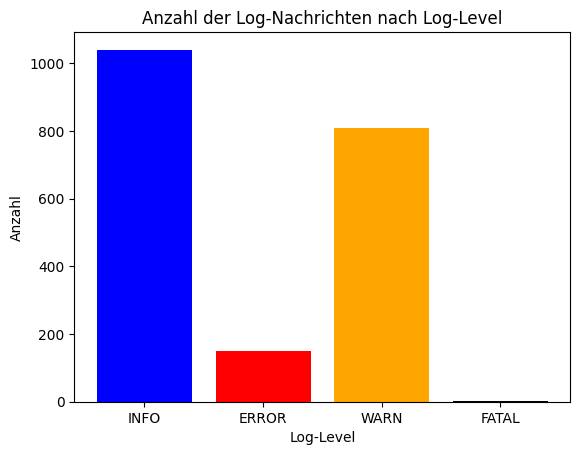

In [ ]:
df_counts_ll = df.groupBy("LogLevel").count().toPandas()
df.groupBy("LogLevel").count().show()

plt.bar(df_counts_ll["LogLevel"], df_counts_ll["count"], color=["blue", "red" , "orange" , "black"])
plt.title("Anzahl der Log-Nachrichten nach Log-Level")
plt.xlabel("Log-Level")
plt.ylabel("Anzahl")
plt.show()

Total Numbers
Percentage
+--------------------+-----+-------------------+
|              Thread|count|         percentage|
+--------------------+-----+-------------------+
|IPC Server handle...|   11| 0.5499999999999999|
|IPC Server handle...|    7|0.35000000000000003|
|IPC Server handle...|    6|                0.3|
|LeaseRenewer:msra...|  653|              32.65|
| eventHandlingThread|    3|               0.15|
|IPC Server handle...|   16|                0.8|
|                main|   53|               2.65|
|ContainerLauncher #3|    4|                0.2|
|IPC Server handle...|   20|                1.0|
|ResponseProcessor...|    2|                0.1|
|IPC Server handle...|    8|                0.4|
|IPC Server Responder|    2|                0.1|
|IPC Server handle...|   23|               1.15|
|ContainerLauncher #6|    4|                0.2|
|ContainerLauncher #9|    4|                0.2|
|IPC Server listen...|    1|               0.05|
|IPC Server handle...|   19|               0

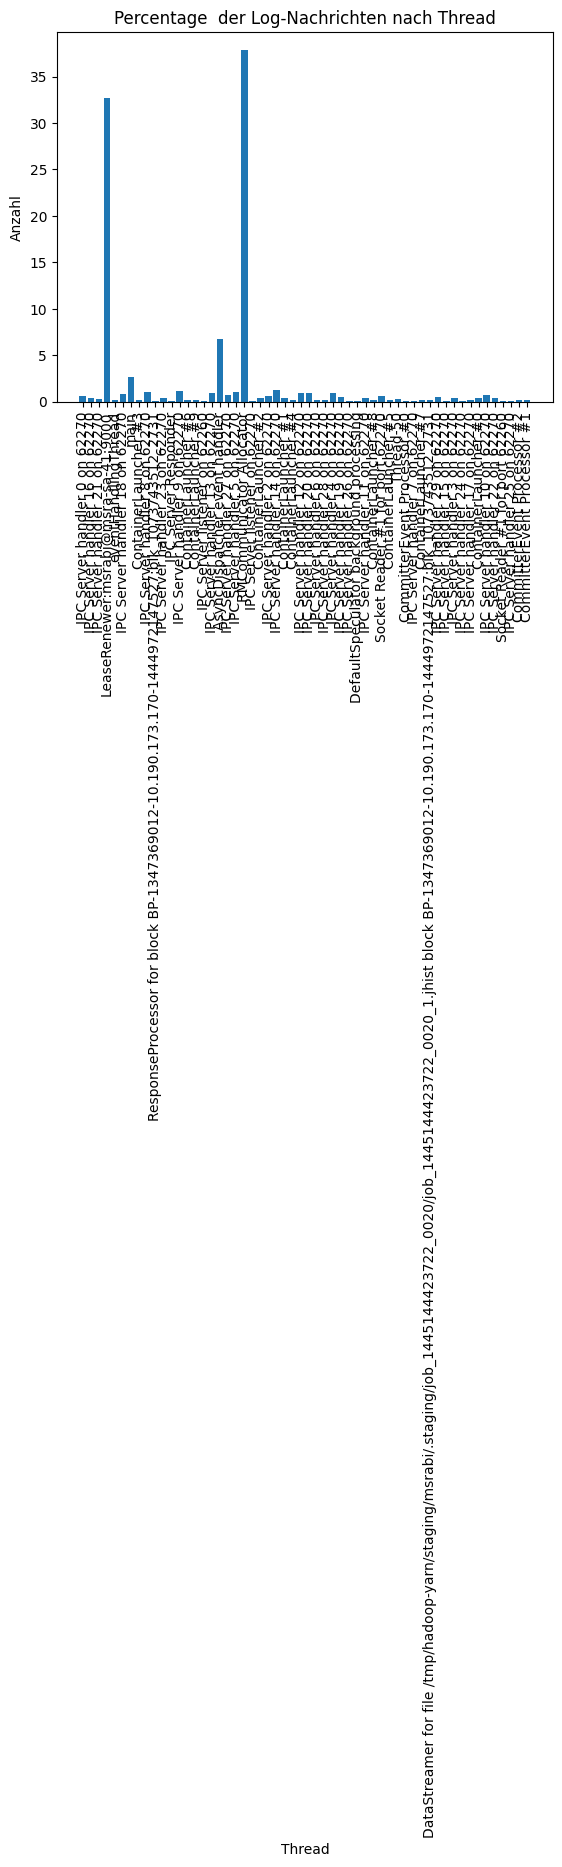

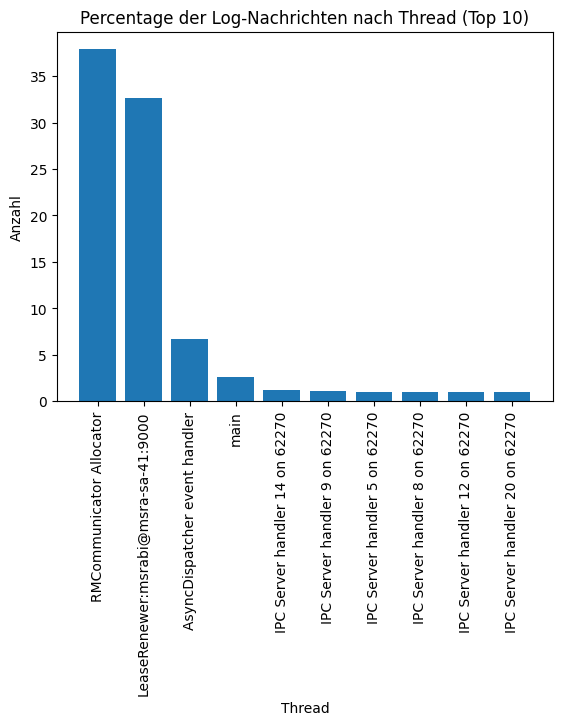

In [ ]:
from pyspark.sql.functions import col

# Zählen Sie die Vorkommen jedes Threads
df_counts_th = df.groupBy("Thread").count()
print("Total Numbers")
df_counts_th

# Berechnen Sie die Gesamtzahl aller Zeilen
total_count = df_counts_th.agg({"count": "sum"}).collect()[0][0]

# Berechnen Sie die Prozente und fügen Sie eine neue Spalte hinzu
df_percentages_th = df_counts_th.withColumn(
    "percentage", (col("count") / total_count) * 100
)

# Konvertieren Sie das Ergebnis in ein Pandas DataFrame
df_percentages_th_pandas = df_percentages_th.toPandas()

print("Percentage")
df_percentages_th.show()


plt.bar(df_percentages_th_pandas["Thread"], df_percentages_th_pandas["percentage"])
plt.title("Percentage  der Log-Nachrichten nach Thread")
plt.xlabel("Thread")
plt.xticks(rotation=90)
plt.ylabel("Anzahl")
plt.show()

# Plot Just the most 10 important
limit = 10
df_percentages_th_pandas = df_percentages_th_pandas.sort_values(by="percentage", ascending=False).head(limit)

plt.bar(df_percentages_th_pandas["Thread"], df_percentages_th_pandas["percentage"])
plt.title(f"Percentage der Log-Nachrichten nach Thread (Top {limit})")
plt.xlabel("Thread")
plt.xticks(rotation=90)
plt.ylabel("Anzahl")
plt.show()

Total Numbers
Percentage
+--------------------+-----+-------------------+
|               Class|count|         percentage|
+--------------------+-----+-------------------+
|mapreduce.v2.app....|    1|               0.05|
|yarn.factories.im...|    1|               0.05|
|yarn.client.api.i...|   14| 0.7000000000000001|
|mapreduce.v2.app....|    5|               0.25|
|mapreduce.v2.app....|   24|                1.2|
|     org.mortbay.log|    4|                0.2|
|mapred.TaskAttemp...|  314|               15.7|
|mapreduce.v2.app....|    7|0.35000000000000003|
|mapreduce.v2.jobh...|    3|               0.15|
|mapreduce.v2.app....|   60|                3.0|
|mapreduce.jobhist...|    3|               0.15|
|mapreduce.v2.app....|  457|              22.85|
|yarn.util.RackRes...|   39|               1.95|
|yarn.event.AsyncD...|    9|0.44999999999999996|
|      hdfs.DFSClient|    4|                0.2|
|          ipc.Client|  622|               31.1|
|mapreduce.v2.app....|    8|                

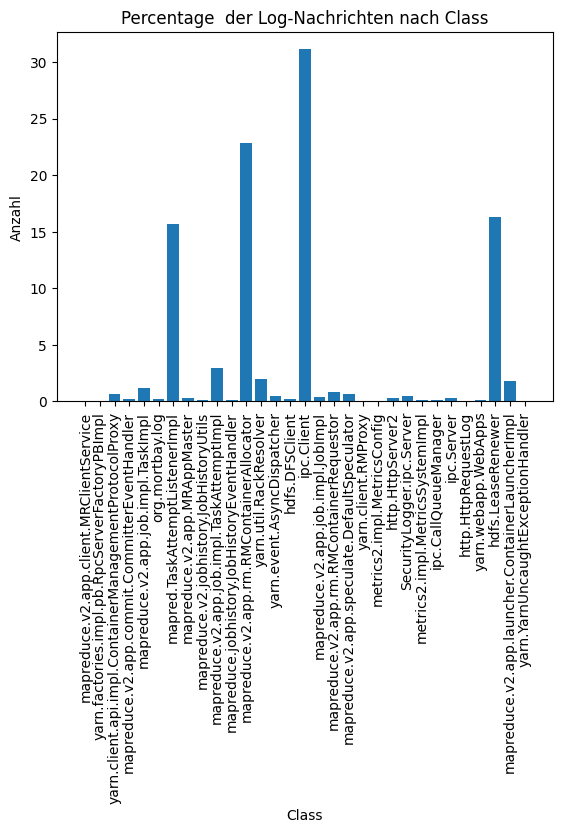

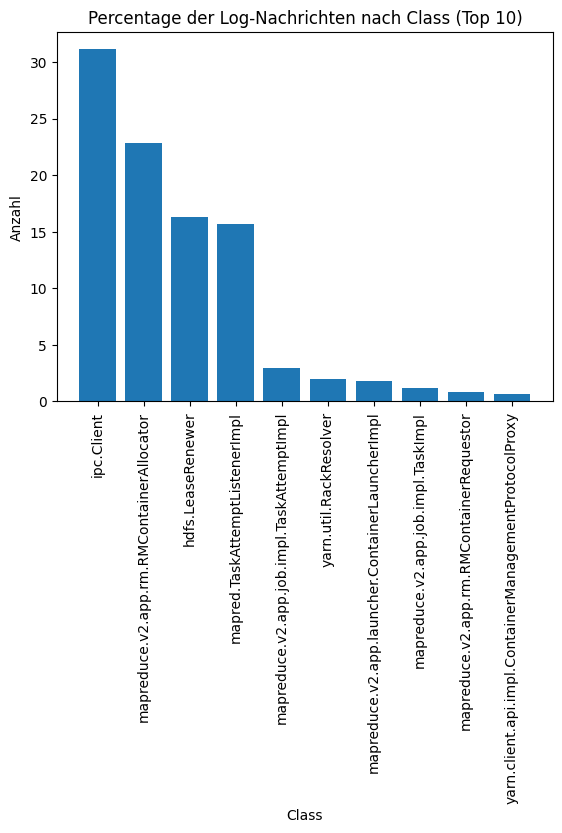

In [ ]:
from pyspark.sql.functions import col

# Zählen Sie die Vorkommen jedes Threads
df_counts_cl = df.groupBy("Class").count()
print("Total Numbers")
df_counts_cl

# Berechnen Sie die Gesamtzahl aller Zeilen
total_count = df_counts_cl.agg({"count": "sum"}).collect()[0][0]

# Berechnen Sie die Prozente und fügen Sie eine neue Spalte hinzu
df_percentages_cl = df_counts_cl.withColumn(
    "percentage", (col("count") / total_count) * 100
)

# Konvertieren Sie das Ergebnis in ein Pandas DataFrame
df_percentages_cl_pandas = df_percentages_cl.toPandas()

print("Percentage")
df_percentages_cl.show()

plt.bar(df_percentages_cl_pandas["Class"], df_percentages_cl_pandas["percentage"])
plt.title("Percentage  der Log-Nachrichten nach Class")
plt.xlabel("Class")
plt.xticks(rotation=90)
plt.ylabel("Anzahl")
plt.show()

# Plot Just the most 10 important
limit = 10
df_percentages_cl_pandas = df_percentages_cl_pandas.sort_values(by="percentage", ascending=False).head(limit)

plt.bar(df_percentages_cl_pandas["Class"], df_percentages_cl_pandas["percentage"])
plt.title(f"Percentage der Log-Nachrichten nach Class (Top {limit})")
plt.xlabel("Class")
plt.xticks(rotation=90)
plt.ylabel("Anzahl")
plt.show()

In [ ]:
df_errors = df.filter(df.LogLevel == "ERROR")

# Error Threads
df_errors_grp_th = df_errors.groupBy("Thread").count()
df_errors_grp_th.show(truncate=False)

# Error Classes
df_errors_grp_cl = df_errors.groupBy("Class").count()
df_errors_grp_cl.show(truncate=False)


+------------------------+-----+
|Thread                  |count|
+------------------------+-----+
|RMCommunicator Allocator|148  |
|eventHandlingThread     |2    |
+------------------------+-----+

+-------------------------------------------+-----+
|Class                                      |count|
+-------------------------------------------+-----+
|mapreduce.v2.app.rm.RMContainerAllocator   |148  |
|mapreduce.jobhistory.JobHistoryEventHandler|1    |
|yarn.YarnUncaughtExceptionHandler          |1    |
+-------------------------------------------+-----+



In [ ]:
df_errors.show(5)

+--------------------+--------+--------------------+--------------------+--------------------+
|           Timestamp|LogLevel|              Thread|               Class|             Message|
+--------------------+--------+--------------------+--------------------+--------------------+
|2015-10-18 18:04:...|   ERROR|RMCommunicator Al...|mapreduce.v2.app....|Container complet...|
|2015-10-18 18:06:...|   ERROR|RMCommunicator Al...|mapreduce.v2.app....|ERROR IN CONTACTI...|
|2015-10-18 18:06:...|   ERROR|RMCommunicator Al...|mapreduce.v2.app....|ERROR IN CONTACTI...|
|2015-10-18 18:06:...|   ERROR|RMCommunicator Al...|mapreduce.v2.app....|ERROR IN CONTACTI...|
|2015-10-18 18:06:...|   ERROR|RMCommunicator Al...|mapreduce.v2.app....|ERROR IN CONTACTI...|
+--------------------+--------+--------------------+--------------------+--------------------+
only showing top 5 rows


# Interpretation und Zusammenfassung

Die Meisten sind INFO Logs und nur Wenige sind Fehler --> Dann noch untersuchen warum genau ein Fehler eingetroffen ist und vor Allem wann

# Hinweis zur Verwendung von generativer KI


Dieser Code wurde unter Verwendung eines KI-Modells (Google Gemini 2.5 Flash) zur Unterstützung entwickelt. Das KI-Modell wurde verwendet, um die Markdowns zu formatieren, Erklärungen bereitzustellen und Vorschläge für die Implementierung zu machen. Die endgültige Validierung, Anpassung und Verantwortung für die Korrektheit des Codes und der Erklärungen liegt beim Autor.
